# Basic text classification.

This practice demostrates text classification starting from a plain text files stored on disk. Training a binary classifier to perform setiment analysis on a IMDB dataset. At the end of the notebook, there is an exercise to try, in which we will train a multi-class classifier to predict the tag for a programming question on StackOverflow.

In [1]:
import matplotlib.pylab as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2021-07-20 21:29:09.805820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-20 21:29:09.805850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.__version__)

2.5.0


# Sentiment analysis

This notebook trains a setiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*-or two-class-classification, an important and widely applicable kind of machine learning problem.

Using the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced* meaning they contain an equal number of positive and negative reviews.

# Download and explore the IMDB dataset

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1', url,
                                  untar=True)
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
dataset_dir

'/home/leno/.keras/datasets/aclImdb'

In [5]:
os.listdir(dataset_dir)

['imdb.vocab', 'test', 'README', 'imdbEr.txt', 'train']

In [6]:
train_dir =os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsup',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'neg']

The ```aclImdb/train/pos``` and ```aclImdb/train/neg``` directories contain many text files, each of which is a single movie review. Let's take a look at one of them

In [7]:
root_dir = os.getcwd()
full_dir_train = os.path.join(root_dir, train_dir)
sample_file = os.path.join(root_dir, train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset

Next you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful ```text_dataset_from_directory``` utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for a binary classification, you will need two folders on disk, corresponding to a ```class_a``` and ```class_b```. These will be the positive and regative movie reviews, which can be found in ```aclImdb/train/pos/``` and ```aclImdb/train/neg```. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [8]:
remove_dir = os.path.join(root_dir, train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, using ```text_dataset_from_directory``` utility to create a labeled ```tf.data.Dataset``` which ```tf.data``` is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation and test.

The IMDB dataset has been already divided into train and test, but it lacks a validation set. Now create a validation set using 80:20 split of the training data by using the ```validation_split``` argument below.

In [9]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(full_dir_train,
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-07-20 21:29:24.942047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-20 21:29:24.942070: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-20 21:29:24.942087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (leno-lab): /proc/driver/nvidia/version does not exist
2021-07-20 21:29:24.942295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As you can see, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to ```model.fit```. If you're new to ```tf.data```, you can also iterate over the dataset and print out few examples as follows.

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2021-07-20 21:29:24.972100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-20 21:29:24.972727: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3194440000 Hz


Notice that the reviews contain raw text (with punctuation and ocassional HTML tags like ```<br/>```.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews. you can check the ```class_names``` property on the dataset.

In [11]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, create the validation and test dataset. Using the remaining 5,000 reviews from the training set for validation.

### Note : When using the ```validation_split``` and ```subset``` arguments, make sure to specify a random seed, or to pass ```shuffle=False```, so that the validation and training splits have no overlap.

In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(full_dir_train,
                                                                batch_size=batch_size,
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
test_dir =os.path.join(dataset_dir, 'test')
full_dir_test = os.path.join(root_dir, test_dir)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(full_dir_test,
                                                                 batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training

Next, standarize, tokenize, and vectorize the data using the helpful ```preprocessing.TextVectorization``` layer.

Standarization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As seeing above, the reviews contain various HTML tags like ```<br/>```. These tags will not be removed by the default standarizer ```TextVectorization``` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custon standarization function to remove the HTML.

# Note: to prevent train/test skew (also know as train/serving skew). It is important to preprocess the data indentically at train and test time. To facilitate this, ```TextVectorization``` layer can be included directly inside your model, as shown later in this notebook.

In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

Next, create ```TextVectorization``` layer. This layer is to standarize, tokenize, and vectorize our data. You set the ```output_mode``` to ```int``` to create unique integer indeces for each token (word). 

Note that you're using default split function, and the custom stadardization function you defined above. You'll also define some constants for the model, like an explicit maximun ```sequence_length```, which will cause the layer to pad or truncate sequences to exactly ```sequence_length``` values.

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize=custom_standardization, max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

Next, call ```adapt``` to fit the state of preprocessing layer to the dataset. This will cause the model to build an index of strings and integers.

*Note: it's important to only use your training data when calling adapt(using the test set would leak information)* 

In [16]:
# Make a text-only dataset (without labels), then call adapt.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

A new function to see the result of using this layer to preprocess some data.

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 --->", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 ---> night
Vocabulary size: 10000


Now apply ```TextVectorization``` layer created earlier to the train, validation and test dataset. 

In [20]:
train_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

```.cache()``` keeps data in memory after it's loaded off disk. This will ensure that dataset does not become a bottleneck while training your model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

```prefectch()``` overlaps data preprocessing and model execution while training.

*Note: check https://www.tensorflow.org/guide/data_performance* 

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [22]:
embedding_dim = 16

In [23]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:
    1. The first layer is an ```Embedding```. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The result dimensions are: ```(batch, sequence, embedding)```. To learn more about embeddings, see https://www.tensorflow.org/tutorials/text/word_embeddings.
    2. Next, a ```GlobalAveragePooling1D``` layers returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
    3. This fixed-length output vector is piped through a fully-connected (```Dense```) layer with 16 hidden units.
    4. The last layer is densely connected with a single output node.
    
 # Loss function and optimizer
 
 A model needs a loss function and an optimizer for training. Since this is a binary classification problem model outputs a probability (a single-unit layer with sigmoid activation), we use here ```losses.BinaryCrossentropy``` loss function.
 
 Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model

You will train the model by passing the ```dataset``` object to the fit method.

In [26]:
epochs = 10 
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
782/782 [==============================] - 5s 5ms/step - loss: 0.6511 - binary_accuracy: 0.7182 - val_loss: 0.5879 - val_binary_accuracy: 0.7654
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.5100 - binary_accuracy: 0.8153 - val_loss: 0.4641 - val_binary_accuracy: 0.8268
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4046 - binary_accuracy: 0.8582 - val_loss: 0.3956 - val_binary_accuracy: 0.8488
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.3441 - binary_accuracy: 0.8770 - val_loss: 0.3598 - val_binary_accuracy: 0.8558
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.3051 - binary_accuracy: 0.8880 - val_loss: 0.3392 - val_binary_accuracy: 0.8594
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2777 - binary_accuracy: 0.8969 - val_loss: 0.3271 - val_binary_accuracy: 0.8646
Epoch 7/10
782/782 [==============================] - 4s 5ms/ste

# Evaluate the model

Let's see how the model performs. Two values will be returned. Loss(a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.1976 - binary_accuracy: 0.9276
Loss:  0.19761088490486145
Accuracy:  0.9275599718093872


This approach gives an accuracy of about 92%

# Create a plot of accuracy and loss over time

```model.fit()``` returns a ```History``` object that contains dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

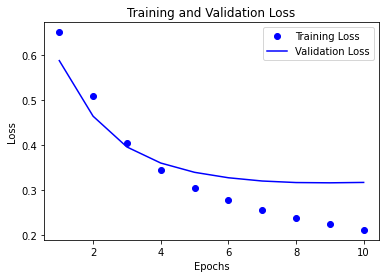

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training Loss')
# b is for "Solid Blue"
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

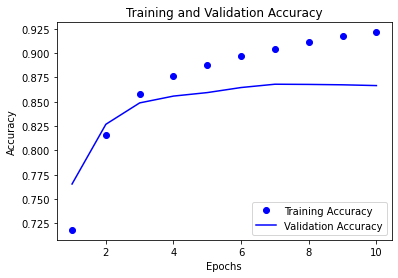

In [30]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training *loss decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization-it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy-they seems to peak before the training accuracy. This is an example of overfitting: The model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do is to use the ```tf.keras.callbacks.EarlyStopping``` callback.

# Export the model 

In the code above, you applied the ```TextVectorization``` layer to the dataset before feeding text to the model, If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include ```TextVectorization``` layer inside your model. To do so, you can create a new model using the weights of the model just trained.

In [31]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings.
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.1976 - accuracy: 0.9276
0.9275599718093872


# Inference on new data

To get predictions for new examples, you can simply call ```model.predict()```

In [32]:
examples = [
    'The movie was great!',
    'The movie was okay.',
    'The movie was terrible...'
]

In [33]:
export_model.predict(examples)

array([[0.7278813 ],
       [0.5214233 ],
       [0.35994366]], dtype=float32)

Including the text preprocessing logic inside your model enables you to exoirt a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply the ```TextVectorization``` layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training GPU. So, if you're training the model on the GPU, you probably want to go with this option to get the best performance while developing the model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment. 

https://www.tensorflow.org/tutorials/keras/save_and_load

# Exercise: Multi-class classification.

As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on Stack Overflow.

A dataset has been prepared for you to use containing the body of several thousand programming questions(For example: "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript or Java). The task is to take a question as input, and predict the appropiate tag, in this case, Python.

The dataset contains several thousand questions extracted from the much larger public Stack Overflow dataset on BigQuery, which contains more than 17 million posts.

https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow